In [1]:
# Load the dataset
import pandas as pd

df = pd.read_csv('../datasets/treated/HaLT-SubjectA-160223.csv')
df = df.sort_values(by=df.columns[0])
df = df.drop(df.columns[0], axis=1)
df.head()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5,Marker
27232,-4.16,12.80,-6.16,1.66,-0.86,1.46,-1.43,-1.92,-0.02,-1.42,...,6.29,-3.82,0.99,-1.31,-2.62,1.07,2.60,-0.96,-0.11,0
22201,-6.68,14.11,-6.04,1.44,-2.30,0.87,-0.53,-0.08,0.10,-0.22,...,5.06,-4.14,1.42,-2.06,-1.17,1.68,2.26,-0.92,0.19,0
3773,-8.79,13.64,-8.61,2.38,-3.34,2.10,0.04,3.84,2.44,3.17,...,4.95,-2.66,3.54,1.12,5.75,-0.53,0.52,2.09,0.26,0
5995,-2.25,14.96,-4.80,0.86,-3.18,2.41,-3.71,0.72,-2.23,1.93,...,5.34,-3.09,2.54,-3.26,1.15,-1.01,0.08,-0.02,-0.31,0
17313,-0.09,13.47,3.72,0.12,0.00,0.06,1.20,3.26,3.48,3.11,...,0.07,-1.03,-1.43,-0.48,2.81,3.98,2.81,1.99,0.33,0


In [2]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
import torch.utils.data as data
import numpy as np

# Define dataloaders
BATCH_SIZE = 100
classes = np.unique(df['Marker'])
# features = df[['Cz', 'C3', 'A1', 'F3', 'P3']]
features = df.drop(['Marker'], axis=1)

# use 20% of training data for validation
train_set_size = int(len(df) * 0.8)
valid_set_size = len(df) - train_set_size

train_set = features[:][:train_set_size]
valid_set = features[:][train_set_size:]

train_data_y = torch.tensor(df['Marker'][:train_set_size].values).type(torch.LongTensor) 
validation_data_y = torch.tensor(df['Marker'][train_set_size:].values).type(torch.LongTensor) 

train_data_x = torch.tensor(train_set.values).type(torch.LongTensor) 
validation_data_x = torch.tensor(valid_set.values).type(torch.LongTensor) 

train_tensor = data.TensorDataset(train_data_x, train_data_y)
validation_tensor = data.TensorDataset(validation_data_x, validation_data_y)

train_loader = data.DataLoader(train_tensor, batch_size=BATCH_SIZE, num_workers=8)
validation_loader = data.DataLoader(validation_tensor, batch_size=BATCH_SIZE, num_workers=8)



In [4]:
# Train NN
import datetime
import time
from tqdm import tqdm


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    total_start = datetime.datetime.now()
    correct = 0
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred, _ = model.liquid.forward(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        pred = model.softmax(pred)
        correct += torch.eq(torch.argmax(pred, dim=1), y).type(torch.float).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(f'Training time: {(datetime.datetime.now() - total_start).total_seconds()}')
    correct /= size
    return loss.item(), correct


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, _ = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += torch.eq(torch.argmax(pred, dim=1), y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

    return test_loss, correct


In [5]:
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import CfC

class LiquidBlock(nn.Module):
    def __init__(self, units=20, out_features=10, in_features=5):
        super().__init__()
        wiring = AutoNCP(units, out_features)
        self.units = units
        self.liquid = CfC(in_features, wiring, return_sequences=True, batch_first=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, state=None):
        x, hx = self.liquid.forward(input=x, hx=state)
        return self.softmax(x), hx

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
model_units = 125
decay_rate = 0.85

model = LiquidBlock(units=model_units, out_features=len(classes), in_features=len(features.columns)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)

epochs = 40
history = []

print(f'MODEL PARAMETERS: {count_parameters(model)}')

Adjusting learning rate of group 0 to 1.0000e-03.
MODEL PARAMETERS: 50608


In [7]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(validation_loader, model, loss_fn)
    lr_scheduler.step()
    epoch = {'val': {'loss': test_loss, 'acc': test_acc}, 'train': {'loss': train_loss, 'acc': train_acc}}
    history.append(epoch)

print("Done!")

Epoch 1
-------------------------------
loss: 1.967701  [  100/174484]
loss: 1.998804  [10100/174484]
loss: 1.874206  [20100/174484]
loss: 1.637869  [30100/174484]
loss: 1.708469  [40100/174484]
loss: 1.749325  [50100/174484]
loss: 2.222571  [60100/174484]
loss: 1.961224  [70100/174484]
loss: 1.644373  [80100/174484]
loss: 1.589644  [90100/174484]
loss: 1.714857  [100100/174484]
loss: 1.943427  [110100/174484]
loss: 1.394686  [120100/174484]
loss: 1.911911  [130100/174484]
loss: 1.780214  [140100/174484]
loss: 1.768777  [150100/174484]
loss: 1.459756  [160100/174484]
loss: 2.094970  [170100/174484]
Training time: 254.379782
Test Error: 
 Accuracy: 34.7%, Avg loss: 1.880772

Adjusting learning rate of group 0 to 8.5000e-04.
Epoch 2
-------------------------------
loss: 1.482405  [  100/174484]
loss: 1.411397  [10100/174484]
loss: 1.516104  [20100/174484]
loss: 1.597649  [30100/174484]
loss: 1.780403  [40100/174484]
loss: 1.466652  [50100/174484]
loss: 1.951030  [60100/174484]
loss: 1.87

In [8]:
print(history)

import json

train_log = {
    'decay_rate': decay_rate,
    'inputs': model.liquid.input_size,
    'batch_size': BATCH_SIZE,
    'learning_rate': learning_rate,
    'units': model_units,
    'num_epochs': epochs,
    'epochs': history,
}

with open(f'log/pytorch/history_{datetime.datetime.timestamp(datetime.datetime.now())}.json', 'w', encoding='utf-8') as f:
    json.dump(train_log, f, ensure_ascii=False, indent=4)



[{'val': {'loss': 1.880771579676962, 'acc': 0.34739351703268995}, 'train': {'loss': 1.9330129623413086, 'acc': 0.28062745008138285}}, {'val': {'loss': 1.8576758177929666, 'acc': 0.3952821970565311}, 'train': {'loss': 1.9792509078979492, 'acc': 0.34470782421310836}}, {'val': {'loss': 1.8484195582653893, 'acc': 0.41983402870111414}, 'train': {'loss': 1.875624656677246, 'acc': 0.3709509181357603}}, {'val': {'loss': 1.834927721209057, 'acc': 0.44555499518591535}, 'train': {'loss': 1.781227469444275, 'acc': 0.3932566882923363}}, {'val': {'loss': 1.829988562269669, 'acc': 0.44965842923295585}, 'train': {'loss': 1.6213971376419067, 'acc': 0.41087434951055685}}, {'val': {'loss': 1.827634454591869, 'acc': 0.45124019989913344}, 'train': {'loss': 1.6921344995498657, 'acc': 0.41859998624515715}}, {'val': {'loss': 1.8206993496936301, 'acc': 0.46646187703452385}, 'train': {'loss': 1.566605567932129, 'acc': 0.4344352490772793}}, {'val': {'loss': 1.8221364651446483, 'acc': 0.45733804043831094}, 'train

In [9]:
import matplotlib.pyplot as plt

with torch.no_grad():
    prediction, _ = model(torch.tensor(features.values).type(torch.LongTensor).to(device))


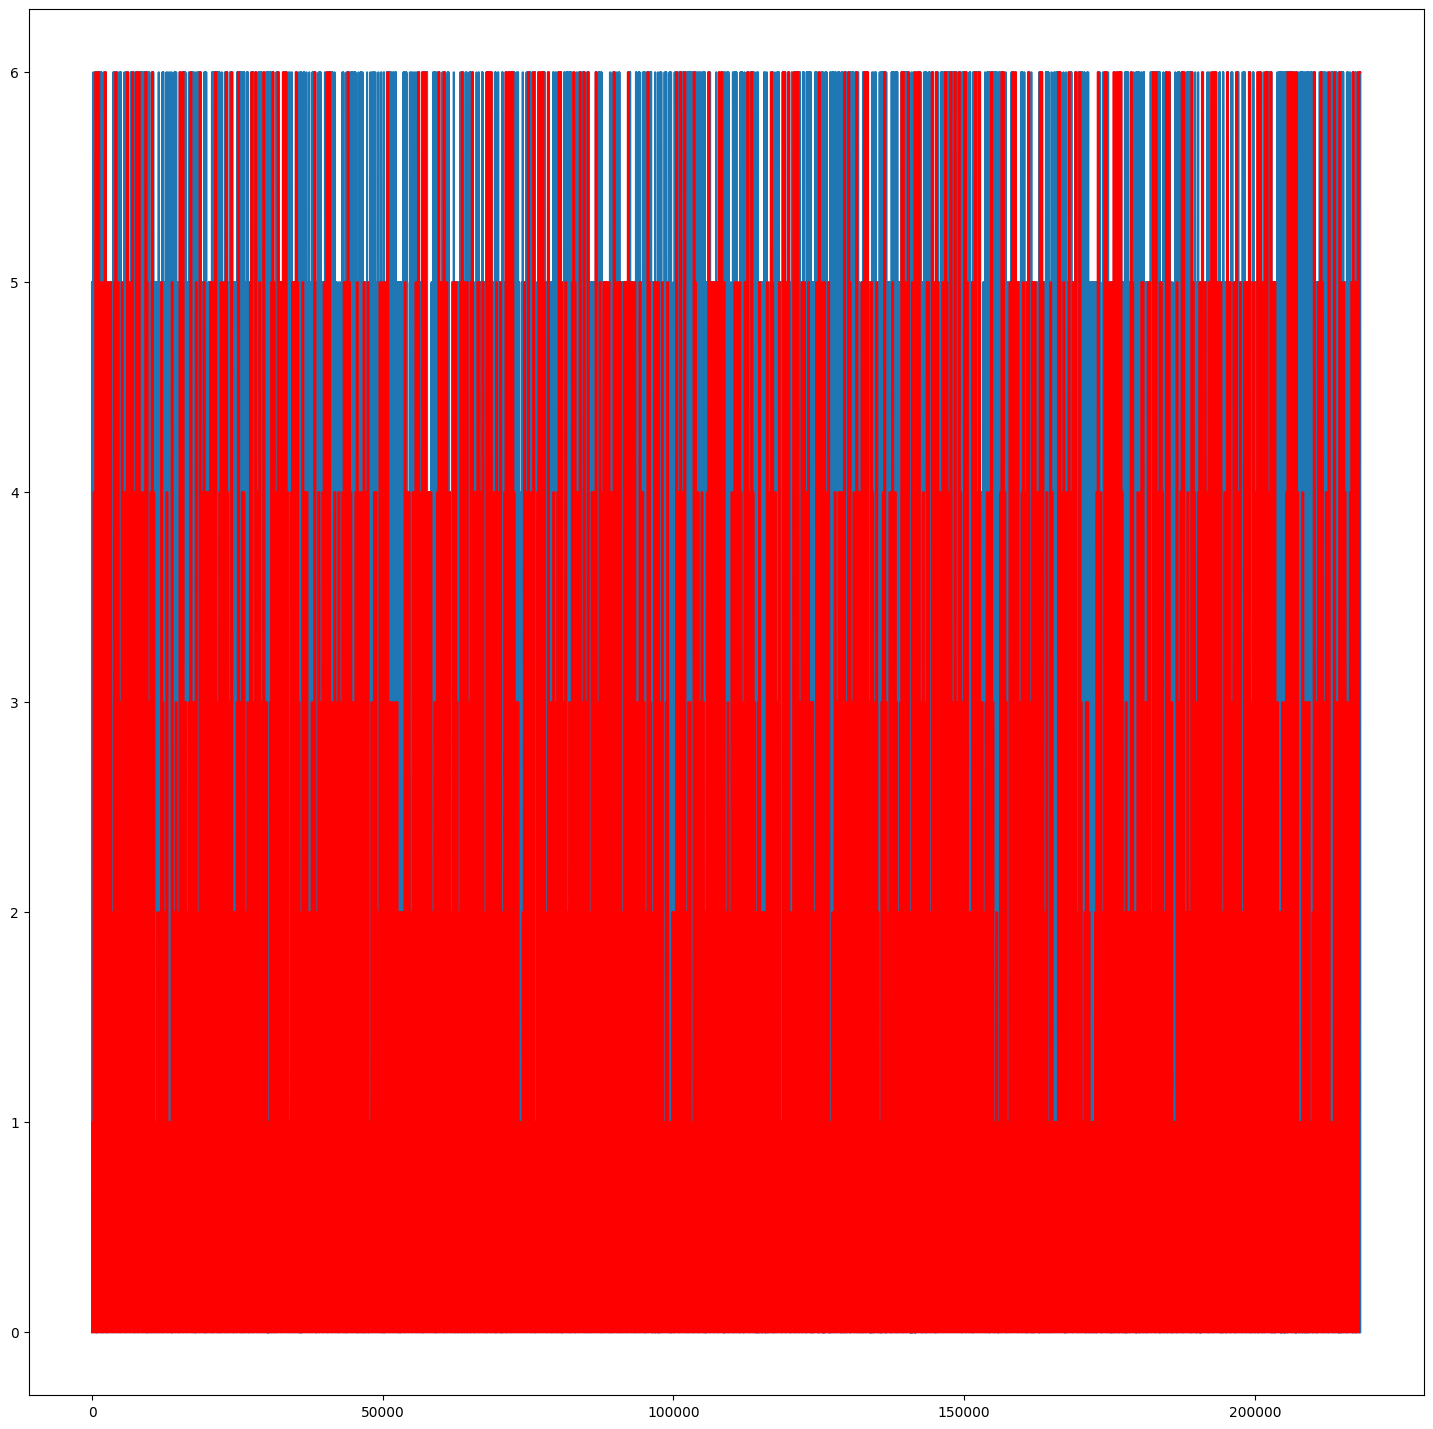

In [10]:
class_pred = []
for one_hot in prediction:
    idx = torch.argmax(one_hot)
    class_pred.append(idx.cpu())



plt.figure(figsize=(18, 18))
plt.plot(range(len(class_pred)), class_pred)
plt.plot(range(len(df['Marker'])), df['Marker'], color='red')

In [11]:
acc = sum(df['Marker'].values == class_pred) / len(df['Marker'])
print(acc)

0.5470642715010132
